# Towards DeepLearning from Scratch with Titatic

## Get the Titanic dataset from Kaggle

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile
        import kaggle
        
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
# Display what we have inside the titanic folder
!ls {path}

gender_submission.csv  test.csv  train.csv


In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Binary classification problem with Survived column as target

## Data Exploration

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.Age.mode()

0    24.0
Name: Age, dtype: float64

## Filling missing value, mode inputing

Mode can have more than one value so we just localize the first one

In [7]:
df.fillna(modes, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S


In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
df.describe(include=[np.object_])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


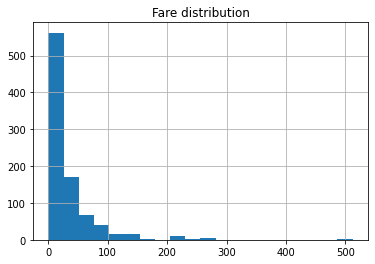

In [11]:
df.Fare.hist(bins=20);
plt.title("Fare distribution");

Linear Models and NN suffers when we feed them long tail distributions, we should try to help making the distribution look better

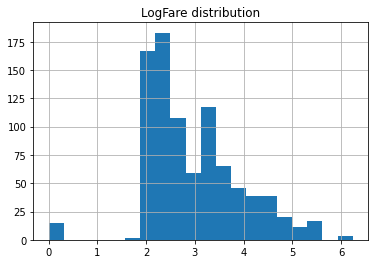

In [12]:
df['LogFare'] = np.log(1 + df.Fare)
df.LogFare.hist(bins=20);
plt.title("LogFare distribution");

# Get dummies cols for categorical columns

In [13]:
# I will avoid using Name, it's useful but out of scope for this nb
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [14]:
added_cols = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols]

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,0,0,1
887,1,0,1,0,0,0,0,1
888,1,0,0,0,1,0,0,1
889,0,1,1,0,0,1,0,0


In [15]:
y = torch.tensor(df.Survived)
y

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [16]:
features_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
X = torch.tensor(df[features_cols].values, dtype=torch.float)
X

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [21]:
vals, idx = X.max(axis=0)
X = X/vals
X

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [22]:
X.shape, y.shape

(torch.Size([891, 12]), torch.Size([891]))

## Linear Model

In [30]:
torch.manual_seed(442)

n_coeffs = X.shape[1]
coeffs = torch.rand(n_coeffs) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [31]:
preds = (X*coeffs).sum(axis=1)
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

# Loss Function MAE

In [32]:
def mae(preds, actuals):
    return torch.abs(preds - actuals).mean()

In [33]:
mae(preds, y)

tensor(0.5200)

In [34]:
def calc_preds(X, coeffs):
    return (X*coeffs).sum(axis=1)

def calc_loss(X, coeffs, actuals):
    preds = calc_preds(X, coeffs)
    return mae(preds, actuals)

## One step SGD

In [36]:
coeffs.requires_grad_()
loss = calc_loss(X, coeffs, y)
loss.backward()
with torch.no_grad():
    coeffs.sub_(0.01*coeffs.grad)
    coeffs.grad.zero_()
    print(calc_loss(X, coeffs, y))

tensor(0.5185)


## Training Loop

In [57]:
from fastai.data.transforms import RandomSplitter
trn_idx, val_idx = RandomSplitter(seed=42)(df)
trn_idx, val_idx

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [58]:
X_train = X[trn_idx]
X_val = X[val_idx]
y_train = y[trn_idx]
y_val = y[val_idx]
len(X_train),len(X_val)

(713, 178)

In [59]:
def init_coeffs():
    return (torch.rand(n_coeffs) - 0.5).requires_grad_()

In [60]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(lr*coeffs.grad)
    coeffs.grad.zero_()

In [61]:
def one_epoch(coeffs, lr):
    loss = calc_loss(X, coeffs, y)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [62]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr)
    return coeffs

In [63]:
coeffs = train_model(18, lr=0.2)

0.520; 0.492; 0.469; 0.445; 0.422; 0.400; 0.378; 0.357; 0.340; 0.337; 0.324; 0.331; 0.304; 0.313; 0.297; 0.297; 0.289; 0.286; 

In [64]:
def show_coeffs(): 
    return dict(zip(features_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2896),
 'SibSp': tensor(0.0857),
 'Parch': tensor(0.2317),
 'LogFare': tensor(-0.0006),
 'Sex_female': tensor(0.2638),
 'Sex_male': tensor(-0.4777),
 'Pclass_1': tensor(0.7004),
 'Pclass_2': tensor(0.4285),
 'Pclass_3': tensor(0.3162),
 'Embarked_C': tensor(0.0879),
 'Embarked_Q': tensor(0.2534),
 'Embarked_S': tensor(0.1565)}

## Measuring Accuracy

In [65]:
preds = calc_preds(X_val, coeffs)
preds

tensor([ 0.8586,  0.0049, -0.1606,  0.0417,  0.0165, -0.0054,  0.6918,  0.7472,  0.1219,  0.6301, -0.1210, -0.1113,  0.0296,  0.7464,
        -0.1282,  0.2160,  0.1436,  0.7966, -0.0342,  0.6241, -0.0920,  0.1762,  0.9598,  0.7626, -0.0776,  0.0155,  0.7820,  0.1545,
        -0.0667,  0.7464,  0.8606,  0.8090, -0.0739, -0.1156,  0.8369,  0.8490,  0.2087,  0.9648, -0.0920,  0.6565,  0.0383, -0.0920,
         0.0521,  0.9359, -0.0776,  0.7808, -0.0995, -0.0417,  0.0049,  0.6567,  0.3379,  0.0929,  0.0822, -0.0957,  0.0129, -0.0088,
         0.0049, -0.1248, -0.0812, -0.1084,  0.2017, -0.0560,  0.0893, -0.0812,  0.6999,  0.3414,  0.0202, -0.1464, -0.0038,  0.6856,
        -0.0993,  0.6580, -0.0052, -0.0921,  0.2920, -0.0631, -0.0920,  0.2519,  0.0383, -0.0631,  0.1634,  1.0742, -0.0884, -0.0920,
         0.6675,  0.0358,  0.2558,  1.1575,  0.6893,  0.0238, -0.1210, -0.0920,  0.9431, -0.1823,  0.7250, -0.0918, -0.0595,  0.7677,
         0.7536,  0.0230, -0.0210,  0.7464, -0.1210, -0.1138, 

In [69]:
((preds >= 0.5) == y_val).float().mean()

tensor(0.7921)

In [70]:
def accuracy(preds, actuals):
    return (actuals.bool() == (preds >= 0.5)).float().mean()

In [72]:
accuracy(preds, y_val)

tensor(0.7921)

## Using Sigmoid, boundary (0,1)

In [73]:
def calc_preds(X, coeffs):
    return torch.sigmoid((X*coeffs).sum(axis=1))

In [76]:
coeffs = train_model(18, lr=100)

0.504; 0.321; 0.270; 0.201; 0.197; 0.195; 0.194; 0.193; 0.193; 0.192; 0.192; 0.192; 0.191; 0.191; 0.191; 0.191; 0.191; 0.191; 

In [77]:
show_coeffs()

{'Age': tensor(-1.4967),
 'SibSp': tensor(-0.9229),
 'Parch': tensor(-0.3052),
 'LogFare': tensor(0.2059),
 'Sex_female': tensor(8.1756),
 'Sex_male': tensor(-10.2695),
 'Pclass_1': tensor(3.7107),
 'Pclass_2': tensor(2.0047),
 'Pclass_3': tensor(-6.1504),
 'Embarked_C': tensor(1.2439),
 'Embarked_Q': tensor(1.8544),
 'Embarked_S': tensor(-4.4805)}

In [78]:
preds = calc_preds(X_val, coeffs)
preds

tensor([    1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.9620,     0.9948,     0.0000,     0.9404,     0.0000,
            0.0000,     0.0000,     0.9708,     0.0000,     0.0000,     0.0000,     0.9950,     0.0000,     0.0492,     0.0000,     0.0000,
            1.0000,     0.9912,     0.0000,     0.0000,     0.0719,     0.0000,     0.0000,     0.9707,     0.9953,     0.0354,     0.0000,
            0.0000,     1.0000,     0.0501,     0.0000,     1.0000,     0.0000,     0.0490,     0.0000,     0.0000,     0.0000,     1.0000,
            0.0000,     0.0337,     0.0000,     0.0000,     0.0000,     0.0575,     0.0036,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0031,     0.0000,     0.0000,     0.0000,     0.9924,     0.0000,
            0.0000,     0.0000,     0.0000,     0.9929,     0.0000,     0.9432,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000, 

In [79]:
accuracy(preds, y_val)

tensor(0.8258)